In [1]:
import sys
import ROOT
import numpy as np
import pandas as pd
import root_pandas
import seaborn as sb
import matplotlib.pyplot as plt
import uproot
import time

from itertools import product

#from root_numpy import root2array

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import QuantileTransformer
import pickle

Welcome to JupyROOT 6.16/00


/Users/jonamotta/anaconda3/envs/python_root/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.3 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)
Using TensorFlow backend.


In [2]:
########################################
### READ TREES AND CREATE DATAFRAMES ###
########################################


# fix random seed for reproducibility
np.random.seed(1986)

#create DataFrames with the values coming from the trees
file_tau = uproot.open('../bc_jpsi_tau_nu_gen_v2.root')
tree_tau = file_tau['tree;1']
tau  = tree_tau.pandas.df(tree_tau.keys())

file_mu = uproot.open('../bc_jpsi_mu_nu_gen_v2.root')
tree_mu = file_mu['tree;2']
mu  = tree_mu.pandas.df(tree_mu.keys())

file_bkg = uproot.open('../jpsi_plusX_background.root')
tree_bkg = file_bkg['tree;1']
bkg = tree_bkg.pandas.df(tree_bkg.keys())

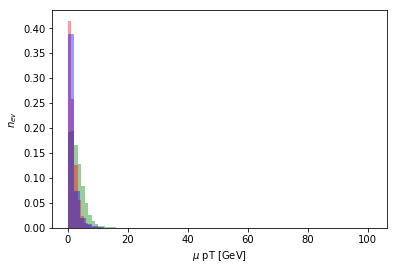

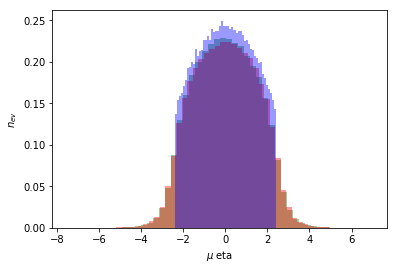

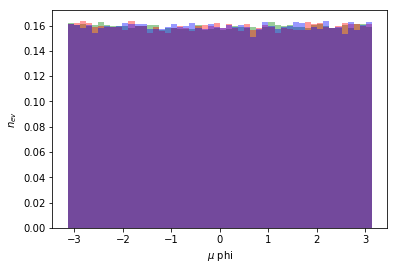

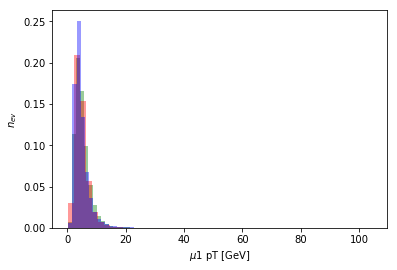

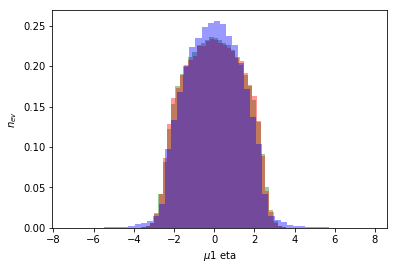

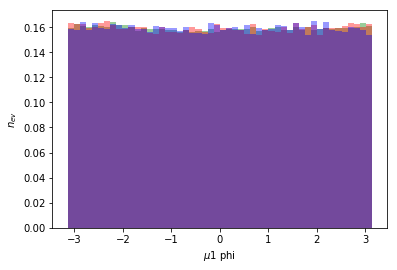

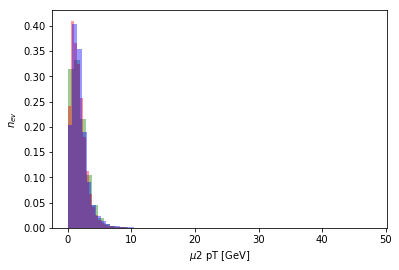

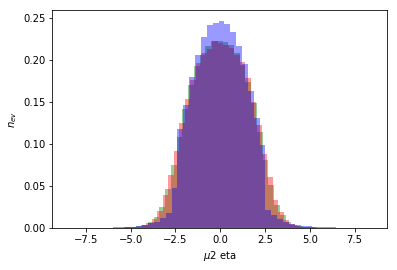

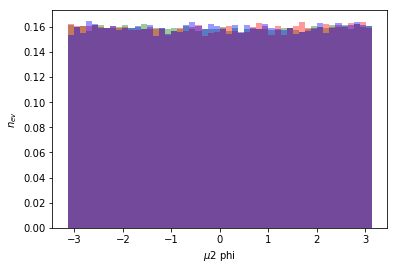

In [3]:
#################################
### SGN AND BKG DISTRIBUTIONS ###
#################################


sb.distplot(mu['mu_pt'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau['mu_pt'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
sb.distplot(bkg['mu_pt'], kde=False, color='b', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu$ pT [GeV]')
plt.ylabel('$n_{ev}$')
plt.show()

sb.distplot(mu['mu_eta'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau['mu_eta'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
sb.distplot(bkg['mu_eta'], kde=False, color='b', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu$ eta')
plt.ylabel('$n_{ev}$')
plt.show()

sb.distplot(mu['mu_phi'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau['mu_phi'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
sb.distplot(bkg['mu_phi'], kde=False, color='b', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu$ phi')
plt.ylabel('$n_{ev}$')
plt.show()

sb.distplot(mu['mu1_pt'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau['mu1_pt'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
sb.distplot(bkg['mu1_pt'], kde=False, color='b', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu1$ pT [GeV]')
plt.ylabel('$n_{ev}$')
plt.show()

sb.distplot(mu['mu1_eta'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau['mu1_eta'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
sb.distplot(bkg['mu1_eta'], kde=False, color='b', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu1$ eta')
plt.ylabel('$n_{ev}$')
plt.show()

sb.distplot(mu['mu1_phi'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau['mu1_phi'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
sb.distplot(bkg['mu1_phi'], kde=False, color='b', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu1$ phi')
plt.ylabel('$n_{ev}$')
plt.show()

sb.distplot(mu['mu2_pt'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau['mu2_pt'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
sb.distplot(bkg['mu2_pt'], kde=False, color='b', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu2$ pT [GeV]')
plt.ylabel('$n_{ev}$')
plt.show()

sb.distplot(mu['mu2_eta'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau['mu2_eta'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
sb.distplot(bkg['mu2_eta'], kde=False, color='b', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu2$ eta')
plt.ylabel('$n_{ev}$')
plt.show()

sb.distplot(mu['mu2_phi'], kde=False, color='g', norm_hist=True, label='$\mu$ channel')
sb.distplot(tau['mu2_phi'], kde=False, color='r', norm_hist=True, label='$\tau$ channel')
sb.distplot(bkg['mu2_phi'], kde=False, color='b', norm_hist=True, label='$\tau$ channel')
plt.xlabel('$\mu2$ phi')
plt.ylabel('$n_{ev}$')
plt.show()

In [4]:
############################################
### ADD NECESSARY FEATURES TO DATAFRAMES ###
############################################


features = [
    'unpairedMuE_muSys_rf', # unpaired muon energy in the rest frame of the jpsi muons sys
    'reco_pT_diff', # difference between the jpsi muons pT
    'jpsi_mass_diffReco', # mu_sys.Mag() - jpsi_mass
    'mu_pt'     ,
    'mu_eta'    ,
    'mu_phi'    ,
    'mu1_pt'    ,
    'mu1_eta'   ,
    'mu1_phi'   ,
    'mu2_pt'    ,
    'mu2_eta'   ,
    'mu2_phi'   ,
]

bkg_events = pd.DataFrame(columns=features)
mu_events = pd.DataFrame(columns=features)
tau_events = pd.DataFrame(columns=features)

bc_vect = ROOT.TLorentzVector()
jpsi_vect = ROOT.TLorentzVector()
mu_vect = ROOT.TLorentzVector()
mu1_vect = ROOT.TLorentzVector()
mu2_vect = ROOT.TLorentzVector()
mu_bkg = ROOT.TLorentzVector()
mu1_bkg = ROOT.TLorentzVector()
mu2_bkg = ROOT.TLorentzVector()
reco_vect = ROOT.TLorentzVector()
PV = ROOT.TVector3()
SV = ROOT.TVector3()
mu_mass = 0.10565837 #GeV/c^2
jpsi_mass = 3.096900 #GeV/c^2
bc_mass = 6.2756 #GeV/c^2
c = 2.99e8 #m/s

# in the following, when creating the TLorentzVector of mu, mu1, mu2 we try to account for the reconstruction error
# made by the tracker and the muon system in the value of pT
# we include a gaussian smearing -> we draw a value of pT from a gaussian centered at the value of the MC pT of the
#                                   muon and with sigma 7% of the value of the MC pT (CMS performance)
start = time.time()
i = 0
k = 0
while i < bkg['run'].count():
    # we take only the events for which the muons atre all inside the acceptance of the CMS detector
    if abs(bkg.at[i,'mu_eta']) < 2.4 and abs(bkg.at[i,'mu1_eta']) < 2.4 and abs(bkg.at[i,'mu2_eta']) < 2.4 and bkg.at[i,'mu_pt'] > 1.0 and bkg.at[i,'mu1_pt'] > 1.0 and bkg.at[i,'mu2_pt'] > 1.0:
        # the muon ID efficiency is 0.96 therefore we first of all draw from a uniform distribution between 0 and 1
        # and we check that the value is <0.96**3 (because we have 3 muons in the final state)
        # if this is not the case we 'throw away' the event
        if np.random.uniform(0,1) < 0.96**3:
            # the following ifs look for events in the barrel, else they are in the endcap
            # background events
            if abs(bkg.at[i,'mu_eta']) < 1.2 and bkg.at[i,'mu_pt'] > 3:
                mu_vect.SetPtEtaPhiM(max(np.random.normal(bkg.at[i,'mu_pt'], bkg.at[i,'mu_pt']*1/100),0), bkg.at[i,'mu_eta'], bkg.at[i,'mu_phi'],mu_mass)
            else:
                mu_vect.SetPtEtaPhiM(max(np.random.normal(bkg.at[i,'mu_pt'], bkg.at[i,'mu_pt']*3/100),0), bkg.at[i,'mu_eta'], bkg.at[i,'mu_phi'],mu_mass)
            if abs(bkg.at[i,'mu1_eta']) < 1.2 and bkg.at[i,'mu1_pt'] > 3:
                mu1_vect.SetPtEtaPhiM(max(np.random.normal(bkg.at[i,'mu1_pt'], bkg.at[i,'mu1_pt']*1/100),0), bkg.at[i,'mu1_eta'], bkg.at[i,'mu1_phi'],mu_mass)
            else:
                mu1_vect.SetPtEtaPhiM(max(np.random.normal(bkg.at[i,'mu1_pt'], bkg.at[i,'mu1_pt']*3/100),0), bkg.at[i,'mu1_eta'], bkg.at[i,'mu1_phi'],mu_mass)
            if abs(bkg.at[i,'mu2_eta']) < 1.2 and bkg.at[i,'mu2_pt'] > 3:
                mu2_vect.SetPtEtaPhiM(max(np.random.normal(bkg.at[i,'mu2_pt'], bkg.at[i,'mu2_pt']*1/100),0), bkg.at[i,'mu2_eta'], bkg.at[i,'mu2_phi'],mu_mass)
            else:
                mu2_vect.SetPtEtaPhiM(max(np.random.normal(bkg.at[i,'mu2_pt'], bkg.at[i,'mu2_pt']*3/100),0), bkg.at[i,'mu2_eta'], bkg.at[i,'mu2_phi'],mu_mass)
            
            reco_vect = mu_vect + mu1_vect + mu2_vect
            
            # using the reconstruction of pT  
            bc_pTreco = bc_mass * reco_vect.Pt() / reco_vect.Mag() 
            bc_vect.SetPtEtaPhiM(bc_pTreco,mu.at[i,'bc_eta'],mu.at[i,'bc_phi'],bc_mass)
            
            # we look for the best roconstruction of the jpsi 
            muons = [mu_vect,mu1_vect,mu2_vect]
            muons_charge = [bkg.at[i,'mu_charge'],bkg.at[i,'mu1_charge'],bkg.at[i,'mu2_charge']]
            if muons_charge[0] != muons_charge[1]:
                pair1_vect = muons[0] + muons[1]
                unpaired_mu1 = muons[2]
                pair2_vect = muons[1] + muons[2]
                unpaired_mu2 = muons[0]
            else:
                pair1_vect = muons[0] + muons[2]
                unpaired_mu1 = muons[1]
                pair2_vect = muons[1] + muons[2]
                unpaired_mu2 = muons[0]

            if (abs(pair1_vect.Mag() - jpsi_mass)) < abs((pair2_vect.Mag() - jpsi_mass)):
                bkg_events.at[k,'muon_pair'] = 0 # indicating the best reco is mu+mu1/2
                unpaired_mu = unpaired_mu1
                mu_sys = pair1_vect
            else:
                bkg_events.at[k,'muon_pair'] = 1 # indicating the best reco is mu1+mu2
                unpaired_mu = unpaired_mu2
                mu_sys = pair2_vect
            
            bkg_events.at[k,'unpairedMuE_muSys_rf'] = unpaired_mu.E() * np.cosh(unpaired_mu.Rapidity() - mu_sys.Rapidity())
            bkg_events.at[k,'reco_pT_diff'] = unpaired_mu.Pt() - mu_sys.Pt()
            bkg_events.at[k,'jpsi_mass_diffReco'] = mu_sys.Mag() - jpsi_mass
            
            # add the missing info to the new df
            bkg_events.at[k,'mu1_pt'] = bkg.at[i,'mu1_pt']
            bkg_events.at[k,'mu1_eta'] = bkg.at[i,'mu1_eta']
            bkg_events.at[k,'mu1_phi'] = bkg.at[i,'mu1_phi']
            bkg_events.at[k,'mu2_pt'] = bkg.at[i,'mu2_pt']
            bkg_events.at[k,'mu2_eta'] = bkg.at[i,'mu2_eta']
            bkg_events.at[k,'mu2_phi'] = bkg.at[i,'mu2_phi']
            bkg_events.at[k,'mu_pt'] = bkg.at[i,'mu_pt']
            bkg_events.at[k,'mu_eta'] = bkg.at[i,'mu_eta']
            bkg_events.at[k,'mu_phi'] = bkg.at[i,'mu_phi']
                
            k += 1
                
    i +=1
    
# ------ end one loop, start the other ------ # 
    
i = 0
k = 0
while i < mu['run'].count():
    # we take only the events for which the muons atre all inside the acceptance of the CMS detector
    if abs(mu.at[i,'mu_eta']) < 2.4 and abs(mu.at[i,'mu1_eta']) < 2.4 and abs(mu.at[i,'mu2_eta']) < 2.4 and mu.at[i,'mu_pt'] > 1.0 and mu.at[i,'mu1_pt'] > 1.0 and mu.at[i,'mu2_pt'] > 1.0:
        # the muon ID efficiency is 0.96 therefore we first of all draw from a uniform distribution between 0 and 1
        # and we check that the value is <0.96**3 (because we have 3 muons in the final state)
        # if this is not the case we 'throw away' the event
        if np.random.uniform(0,1) < 0.96**3:
            # the following ifs look for events in the barrel, else they are in the endcap
            if abs(mu.at[i,'mu_eta']) < 1.2 and mu.at[i,'mu_pt'] > 3:
                mu_vect.SetPtEtaPhiM(max(np.random.normal(mu.at[i,'mu_pt'], mu.at[i,'mu_pt']*1/100),0),mu.at[i,'mu_eta'],mu.at[i,'mu_phi'],mu_mass)
            else:
                mu_vect.SetPtEtaPhiM(max(np.random.normal(mu.at[i,'mu_pt'], mu.at[i,'mu_pt']*3/100),0),mu.at[i,'mu_eta'],mu.at[i,'mu_phi'],mu_mass)
            if abs(mu.at[i,'mu1_eta']) < 1.2 and mu.at[i,'mu1_pt'] > 3:
                mu1_vect.SetPtEtaPhiM(max(np.random.normal(mu.at[i,'mu1_pt'], mu.at[i,'mu1_pt']*1/100),0),mu.at[i,'mu1_eta'],mu.at[i,'mu1_phi'],mu_mass)
            else:
                mu1_vect.SetPtEtaPhiM(max(np.random.normal(mu.at[i,'mu1_pt'], mu.at[i,'mu1_pt']*3/100),0),mu.at[i,'mu1_eta'],mu.at[i,'mu1_phi'],mu_mass)
            if abs(mu.at[i,'mu2_eta']) < 1.2 and mu.at[i,'mu2_pt'] > 3:
                mu2_vect.SetPtEtaPhiM(max(np.random.normal(mu.at[i,'mu2_pt'], mu.at[i,'mu2_pt']*1/100),0),mu.at[i,'mu2_eta'],mu.at[i,'mu2_phi'],mu_mass)
            else:
                mu2_vect.SetPtEtaPhiM(max(np.random.normal(mu.at[i,'mu2_pt'], mu.at[i,'mu2_pt']*3/100),0),mu.at[i,'mu2_eta'],mu.at[i,'mu2_phi'],mu_mass)
            
            reco_vect = mu_vect + mu1_vect + mu2_vect
    
            # using the reconstruction of pT  
            bc_pTreco = mu.at[i,'bc_mass'] * reco_vect.Pt() / reco_vect.Mag() 
            bc_vect.SetPtEtaPhiM(mu.at[i,'bc_mass']*reco_vect.Pt()/reco_vect.Mag(),mu.at[i,'bc_eta'],mu.at[i,'bc_phi'],mu.at[i,'bc_mass'])
            
            # we look for the best roconstruction of the jpsi 
            muons = [mu_vect,mu1_vect,mu2_vect]
            muons_charge = [mu.at[i,'mu_charge'],mu.at[i,'mu1_charge'],mu.at[i,'mu2_charge']]
            pair_vect = ROOT.TLorentzVector()
            if muons_charge[0] != muons_charge[1]:
                pair1_vect = muons[0] + muons[1]
                unpaired_mu1 = muons[2]
                pair2_vect = muons[1] + muons[2]
                unpaired_mu2 = muons[0]
            else:
                pair1_vect = muons[0] + muons[2]
                unpaired_mu1 = muons[1]
                pair2_vect = muons[1] + muons[2]
                unpaired_mu2 = muons[0]

            if (abs(pair1_vect.Mag() - jpsi_mass)) < abs((pair2_vect.Mag() - jpsi_mass)):
                mu_events.at[k,'muon_pair'] = 0 # indicating the best reco is mu+mu1/2
                unpaired_mu = unpaired_mu1
                mu_sys = pair1_vect
                q2_vect = bc_vect - pair1_vect
            else:
                mu_events.at[k,'muon_pair'] = 1 # indicating the best reco is mu1+mu2
                unpaired_mu = unpaired_mu2
                mu_sys = pair2_vect
                q2_vect = bc_vect - pair2_vect
            
            # features useful for the sgn-bkg discrimination
            mu_events.at[k,'unpairedMuE_muSys_rf'] = unpaired_mu.E() * np.cosh(unpaired_mu.Rapidity() - mu_sys.Rapidity())
            mu_events.at[k,'reco_pT_diff'] = unpaired_mu.Pt() - mu_sys.Pt()
            mu_events.at[k,'jpsi_mass_diffReco'] = mu_sys.Mag() - jpsi_mass
            
            # features useful for the mu-tau discrimination
            m2_vect = bc_vect - reco_vect
            mu_events.at[k,'m2_miss'] = m2_vect.Mag2()
            mu_events.at[k,'pT_miss'] = m2_vect.Pt()
            mu_events.at[k,'q2'] = q2_vect.Mag2()
            mu_events.at[k,'muE_Brf'] = unpaired_mu.E() * np.cosh(unpaired_mu.Rapidity() - bc_vect.Rapidity())
            
            # add the missing info to the new df
            mu_events.at[k,'mu1_pt'] = mu.at[i,'mu1_pt']
            mu_events.at[k,'mu1_eta'] = mu.at[i,'mu1_eta']
            mu_events.at[k,'mu1_phi'] = mu.at[i,'mu1_phi']
            mu_events.at[k,'mu2_pt'] = mu.at[i,'mu2_pt']
            mu_events.at[k,'mu2_eta'] = mu.at[i,'mu2_eta']
            mu_events.at[k,'mu2_phi'] = mu.at[i,'mu2_phi']
            mu_events.at[k,'mu_pt'] = mu.at[i,'mu_pt']
            mu_events.at[k,'mu_eta'] = mu.at[i,'mu_eta']
            mu_events.at[k,'mu_phi'] = mu.at[i,'mu_phi']
                
            k += 1
                
    i +=1

# ------ end one loop, start the other ------ # 
    
i = 0
k = 0
while i < tau['run'].count():
    # we take only the events for which the muons are all inside the acceptance of the CMS detector
    if abs(tau.at[i,'mu_eta']) < 2.4 and abs(tau.at[i,'mu1_eta']) < 2.4 and abs(tau.at[i,'mu2_eta']) < 2.4 and tau.at[i,'mu_pt'] > 1.0 and tau.at[i,'mu1_pt'] > 1.0 and tau.at[i,'mu2_pt'] > 1.0:
        # the muon ID efficiency is 0.96 therefore we first of all draw from a uniform distribution between 0 and 1
        # and we check that the value is <0.96**3 (because we have 3 muons in the final state)
        # if this is not the case we 'throw away' the event
        if np.random.uniform(0,1) < 0.96**3:
            # the following ifs look for events in the barrel, else they are in the endcap
            if abs(tau.at[i,'mu_eta']) < 1.2 and tau.at[i,'mu_pt'] > 3:
                mu_vect.SetPtEtaPhiM(max(np.random.normal(tau.at[i,'mu_pt'], tau.at[i,'mu_pt']*1/100),0),tau.at[i,'mu_eta'],tau.at[i,'mu_phi'],mu_mass)
            else:
                mu_vect.SetPtEtaPhiM(max(np.random.normal(tau.at[i,'mu_pt'], tau.at[i,'mu_pt']*3/100),0),tau.at[i,'mu_eta'],tau.at[i,'mu_phi'],mu_mass)
            if abs(tau.at[i,'mu1_eta']) < 1.2 and tau.at[i,'mu1_pt'] > 3:
                mu1_vect.SetPtEtaPhiM(max(np.random.normal(tau.at[i,'mu1_pt'], tau.at[i,'mu1_pt']*1/100),0),tau.at[i,'mu1_eta'],tau.at[i,'mu1_phi'],mu_mass)
            else:
                mu1_vect.SetPtEtaPhiM(max(np.random.normal(tau.at[i,'mu1_pt'], tau.at[i,'mu1_pt']*3/100),0),tau.at[i,'mu1_eta'],tau.at[i,'mu1_phi'],mu_mass)
            if abs(tau.at[i,'mu2_eta']) < 1.2 and tau.at[i,'mu2_pt'] > 3:
                mu2_vect.SetPtEtaPhiM(max(np.random.normal(tau.at[i,'mu2_pt'], tau.at[i,'mu2_pt']*1/100),0),tau.at[i,'mu2_eta'],tau.at[i,'mu2_phi'],mu_mass)
            else:
                mu2_vect.SetPtEtaPhiM(max(np.random.normal(tau.at[i,'mu2_pt'], tau.at[i,'mu2_pt']*3/100),0),tau.at[i,'mu2_eta'],tau.at[i,'mu2_phi'],mu_mass)

            reco_vect = mu_vect + mu1_vect + mu2_vect

            # using the reconstruction of pT instead of pZ
            bc_pTreco = (tau.at[i,'bc_mass'] / reco_vect.Mag()) * reco_vect.Pt()
            bc_vect.SetPtEtaPhiM(bc_pTreco,tau.at[i,'bc_eta'],tau.at[i,'bc_phi'],tau.at[i,'bc_mass'])
            
            # using the reconstruction of pT instead of pZ
            bc_pTreco = (bc_mass / reco_vect.Mag()) * reco_vect.Pt()
            bc_vect.SetPtEtaPhiM(bc_pTreco,tau.at[i,'bc_eta'],tau.at[i,'bc_phi'],bc_mass)
            
            # we look for the best roconstruction of the jpsi 
            muons = [mu_vect,mu1_vect,mu2_vect]
            muons_charge = [tau.at[i,'mu_charge'],tau.at[i,'mu1_charge'],tau.at[i,'mu2_charge']]
            if muons_charge[0] != muons_charge[1]:
                pair1_vect = muons[0] + muons[1]
                unpaired_mu1 = muons[2]
                pair2_vect = muons[1] + muons[2]
                unpaired_mu2 = muons[0]
            else:
                pair1_vect = muons[0] + muons[2]
                unpaired_mu1 = muons[1]
                pair2_vect = muons[1] + muons[2]
                unpaired_mu2 = muons[0]

            if (abs(pair1_vect.Mag() - jpsi_mass)) < abs((pair2_vect.Mag() - jpsi_mass)):
                tau_events.at[k,'muon_pair'] = 0 # indicating the best reco is mu+mu1/2
                unpaired_mu = unpaired_mu1
                mu_sys = pair1_vect
                q2_vect = bc_vect - pair1_vect
            else:
                tau_events.at[k,'muon_pair'] = 1 # indicating the best reco is mu1+mu2
                unpaired_mu = unpaired_mu2
                mu_sys = pair2_vect
                q2_vect = bc_vect - pair2_vect
            
            # features useful for the sgn-bkg discrimination
            tau_events.at[k,'unpairedMuE_muSys_rf'] = unpaired_mu.E() * np.cosh(unpaired_mu.Rapidity() - mu_sys.Rapidity())
            tau_events.at[k,'reco_pT_diff'] = unpaired_mu.Pt() - mu_sys.Pt()
            tau_events.at[k,'jpsi_mass_diffReco'] = mu_sys.Mag() - jpsi_mass
            
            # features usefull for the mu-tau discrimination
            m2_vect = bc_vect - reco_vect
            tau_events.at[k,'m2_miss'] = m2_vect.Mag2()
            tau_events.at[k,'pT_miss'] = m2_vect.Pt()
            tau_events.at[k,'q2'] = q2_vect.Mag2()
            tau_events.at[k,'muE_Brf'] = unpaired_mu.E() * np.cosh(unpaired_mu.Rapidity() - bc_vect.Rapidity())
            
            # add the missing info to the new df
            tau_events.at[k,'mu1_pt'] = tau.at[i,'mu1_pt']
            tau_events.at[k,'mu1_eta'] = tau.at[i,'mu1_eta']
            tau_events.at[k,'mu1_phi'] = tau.at[i,'mu1_phi']
            tau_events.at[k,'mu2_pt'] = tau.at[i,'mu2_pt']
            tau_events.at[k,'mu2_eta'] = tau.at[i,'mu2_eta']
            tau_events.at[k,'mu2_phi'] = tau.at[i,'mu2_phi']
            tau_events.at[k,'mu_pt'] = tau.at[i,'mu_pt']
            tau_events.at[k,'mu_eta'] = tau.at[i,'mu_eta']
            tau_events.at[k,'mu_phi'] = tau.at[i,'mu_phi']

            k += 1
                
    i += 1
    
end = time.time()
print 'Running time to add the new vars to the df = %.1f'%(end - start)

Running time to add the new vars to the df = 15130.0


In [5]:
#######################################################
### ADD TARGET COLUMNS AND SAVE CSV FILES OF EVENTS ###
#######################################################

#add the column target to all dataframes
mu['target'] = 1
mu_events['target'] = 1
tau['target'] = 1
tau_events['target'] = 1
bkg['target'] = 0
bkg_events['target'] = 0

bkg_events.to_csv('bkg_events_bkgDiscr.csv')
mu_events.to_csv('mu_events_bkgDiscr.csv')
tau_events.to_csv('tau_events_bkgDiscr.csv')